## Задача №1

Анализ рекламных кампаний.

Исходные данные - лог событий из БД по рекламным кампаниям за месяц - 1_monthly_campaigns_events.csv

**date** - дата <br>
**campaign** - ID рекламной кампании<br>
**source** - ID источника, где была показана реклама<br>
**shows** - события "показ рекламного объявления"<br>
**clicks** - события "клик по рекламному объявлению"<br>
**conversions** - события "конверсия рекламного объявления" (пользователь совершил какое-то определенное действие на странице конечного рекламодателя, это может быть регистрация, установка приложения и т.д.)<br>

_Необходимо провести анализ рекламных кампаний, проанилизровать их поведение на разных источниках в течение месяца. Оценить взаимосвязь кампаний и источников, определить эффективность связок campaign+source по метрикам CTR и click-CR, выявить паттерны поведений._

In [127]:
import pandas as pd
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp


In [128]:
df = pd.read_csv('1_monthly_campaigns_events.csv')

Понять какая комбинация campaign + source является лучшей по метрикам CTR и click-CR

In [129]:
df

,date,campaign,source,shows,clicks,conversions
0,2022-11-01,2,1,78799,1163,58
1,2022-11-01,2,2,421402,9046,24
2,2022-11-01,2,3,647692,14548,100
3,2022-11-01,1,1,158429,4611,32
4,2022-11-01,1,2,936629,58225,150
...,...,...,...,...,...,...
175,2022-11-30,2,2,314301,5695,21
176,2022-11-30,2,3,553240,10542,40
177,2022-11-30,1,1,132136,4981,34
178,2022-11-30,1,2,511290,24376,424


In [130]:
df.source.unique()

array([1, 2, 3], dtype=int64)

Значени на каждую компанию и каждый ресурс ровно один день

### Сгруппируем по компаниям и по ресурсам
Затем расчитаем метрики

In [131]:
df_grouped = df.groupby(['campaign', 'source'], as_index=False).sum()
df_grouped

,campaign,source,shows,clicks,conversions
0,1,1,5895104,248882,1726
1,1,2,25820354,1492241,25317
2,1,3,15369596,910368,15354
3,2,1,2712907,36474,1814
4,2,2,10579289,179408,823
5,2,3,14794036,328301,2023


In [132]:
def add_metrics(df):
    df['ctr'] = round(df.clicks / df.shows * 100, 3)
    df['click_cr'] = round(df.conversions / df.clicks * 100, 3)
    return df.drop(['shows', 'clicks', 'conversions'], axis=1)

df_grouped = add_metrics(df_grouped)

In [133]:
df_grouped.sort_values(by=['ctr', 'click_cr'], ascending=False)

,campaign,source,ctr,click_cr
2,1,3,5.923,1.687
1,1,2,5.779,1.697
0,1,1,4.222,0.694
5,2,3,2.219,0.616
4,2,2,1.696,0.459
3,2,1,1.344,4.973


### Делаем вывод
Лучшая комбинация - campaign = 1, source = 3

### Детальный анализ

можно заметить, что метрик для campaign = 1 и source=3,2 примерно равны
Мы можем предположить, что различий между выборками нет

Стоит провести анализ 


In [134]:
df2 = df.copy()
df2 = add_metrics(df2)

In [135]:
group1 = df2[(df2.campaign == 1) & (df2.source == 1)]
group2 = df2[(df2.campaign == 1) & (df2.source == 2)]
group3 = df2[(df2.campaign == 1) & (df2.source == 3)]


0.3276702282454142


<AxesSubplot:xlabel='ctr', ylabel='Count'>

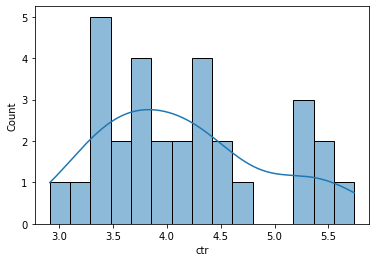

In [136]:
# оценим распределения на нормальность
print(stats.normaltest(group1.ctr).pvalue)
sns.histplot(group1.ctr, bins=15, kde= True)

0.5062106421621669


<AxesSubplot:xlabel='ctr', ylabel='Count'>

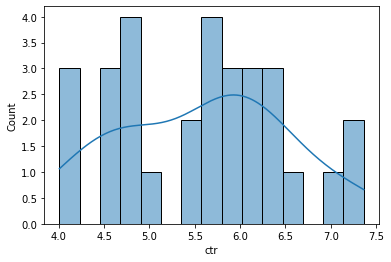

In [137]:
print(stats.normaltest(group2.ctr).pvalue)
sns.histplot(group2.ctr, bins=15, kde= True)

0.015284494097385536


<AxesSubplot:xlabel='ctr', ylabel='Count'>

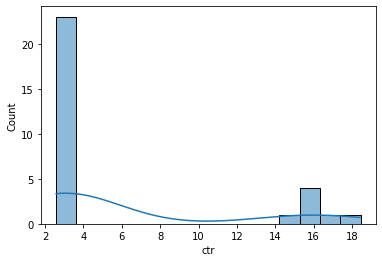

In [138]:
print(stats.normaltest(group3.ctr).pvalue)
sns.histplot(group3.ctr, bins=15, kde= True)

Проведём тест <br>
Гипотеза 0 - в campaign 1 все source из одного распределения - статистической разницы между ними нет<br>
Гипотеза 1 - есть статистическая разница

Используем тест данна для явного понимания разницы между группами

In [143]:
data = [group1.ctr, group2.ctr, group3.ctr]
sp.posthoc_dunn(data, p_adjust = 'bonferroni')

,1,2,3
1,1.000000,0.001001,0.402922
2,0.001001,1.000000,0.000001
3,0.402922,0.000001,1.000000


Скорректированное значение p для разницы между группой 1 и группой 2 составляет 0.001001<br>
Скорректированное значение p для разницы между группой 1 и группой 3 составляет 0.402922<br>
Скорректированное значение p для разницы между группой 2 и группой 3 составляет 0.000001<br>

Статистически не различаются группа 1 и 3 при alpha = 0.05

Вывод: в campaign = 1, между source=1 и source=3 нет статистической разницы

In [124]:
group1 = df2[(df2.campaign == 2) & (df2.source == 1)]
group2 = df2[(df2.campaign == 2) & (df2.source == 2)]
group3 = df2[(df2.campaign == 2) & (df2.source == 3)]

data = [group1.ctr, group2.ctr, group3.ctr]
sp.posthoc_dunn(data, p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,0.000025,5.700918e-14
2,2.517225e-05,1.000000,4.090949e-03
3,5.700918e-14,0.004091,1.000000e+00


Для campaign=2 все группы статистически различаются


### Проведём анализ паттернов поведения

Гипотеза 0 - в выходные конверсия не отличается<br>
Гипотеза 1 - в выходные конверсия другая

In [86]:
df2 = df.copy()

In [87]:
import calendar

def is_holiday(date):
    y, m, d = map(int, date.split('-'))
    day = calendar.weekday(y, m, d)
    if day == 5 or day == 6:
        return 1
    return 0

df2['is_holiday'] = df2.date.apply(is_holiday)

In [88]:
df2 = add_metrics(df2)
df2

,date,campaign,source,is_holiday,ctr,click_cr
0,2022-11-01,2,1,0,1.476,4.987
1,2022-11-01,2,2,0,2.147,0.265
2,2022-11-01,2,3,0,2.246,0.687
3,2022-11-01,1,1,0,2.910,0.694
4,2022-11-01,1,2,0,6.216,0.258
...,...,...,...,...,...,...
175,2022-11-30,2,2,0,1.812,0.369
176,2022-11-30,2,3,0,1.906,0.379
177,2022-11-30,1,1,0,3.770,0.683
178,2022-11-30,1,2,0,4.768,1.739


In [89]:
holidays = df2.loc[df2.is_holiday == 1]
weekday = df2.loc[df2.is_holiday == 0]

<AxesSubplot:xlabel='ctr', ylabel='Count'>

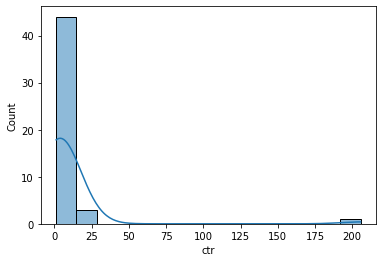

In [90]:
sns.histplot(holidays.ctr, bins=15, kde= True)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

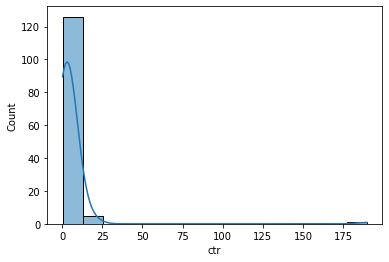

In [91]:
sns.histplot(weekday.ctr, bins=15, kde=True)

Проверка на нормальность
Манауитни для ненормального и т критерий для нормального

In [94]:
for metric in ['ctr', 'click_cr']:
    
    alpha = 0.05
    campaigns = df.campaign.unique()
    for cam in campaigns:
        
        sources = df.source.unique()
        for so in sources:
            
            df_a = weekday.loc[(weekday.campaign == cam) & (weekday.source == so)]
            df_b = holidays.loc[(holidays.campaign == cam) & (holidays.source == so)]
            a_normal = stats.normaltest(df_a[metric]).pvalue > 0.05
            b_normal = stats.normaltest(df_b[metric]).pvalue > 0.05
            
            if a_normal and b_normal:
  
                p_value = stats.ttest_ind(df_a[metric], df_b[metric]).pvalue
            else:
                p_value = stats.mannwhitneyu(df_a[metric], df_b[metric]).pvalue

            if p_value <= alpha:

                print('Отклоняем нулевую гипотезу\nЕсть статистическая разница между буднями и выходными')
                print(f'Для метрики:{metric}\ncampaign={cam}\nsource={so}\n')



Отклоняем нулевую гипотезу
Есть статистическая разница между буднями и выходными
Для метрики:ctr
campaign=2
source=2

Отклоняем нулевую гипотезу
Есть статистическая разница между буднями и выходными
Для метрики:ctr
campaign=2
source=3

Отклоняем нулевую гипотезу
Есть статистическая разница между буднями и выходными
Для метрики:click_cr
campaign=2
source=2



C:\Program Files (x86)\pit\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Program Files (x86)\pit\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Program Files (x86)\pit\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Program Files (x86)\pit\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Program Files (x86)\pit\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=

### Выводы

Наилучшей комбинацией campaign + source является<br>
campaign = 1 source = 3

При этом было обнаружено отсутствие статистической значимости между source 1 и 3 в campaign 1
что говорит о однообразие трафика

Также был выявлен паттерн поведения клиентов, пришедших с campaign = 2 source = 2, 3 в выходные дни

## Задача №2

Анализ корректности применения настроек рекламных кампаний.

Исходные данные - выгрузка из БД событий рекламных кампаний за период времени N - 2_campaigns_events.csv

**campaign** - ID рекламной кампании<br>
**os** - операционная система<br>
**device** - модель девайса<br>
**browser** - браузер<br>
**shows** - показы<br>
**clicks** - клики<br>
Конфигурация настроек рекламных кампаний, полученная из API, актуальная на весь период времени N - 2_campaigns_settings.json

Необходимо проверить, что установленные настройки и таргеты* рекламных кампаний работали корректно.

*В контексте данной задачи, таргеты обознают то, какой трафик хочет получать рекламодатель. Пустой таргет означает, что рекламодателю не принципиально какой будет трафик по N-ному параметру.

p.s: в этой задаче всего несколько кампаний и их настройки можно проверить визуально, сравнив 2 набора данных, но её необходимо решить таким образом, чтобы способ решения был актуален и для тысячи кампаний.

In [1]:
import pandas as pd

In [2]:
campaigns = pd.read_csv('2_campaigns_events.csv')
settings = pd.read_json('2_campaigns_settings.json')

In [3]:
campaigns

,campaign,os,device,browser,shows,clicks
0,1,Android,galaxy s20,chrome,100000,5000
1,4,Windows,desktop,firefox,60000,9000
2,3,Windows,desktop,yandex,7000,200
3,5,Android,iphone 17 ultra,chrome,6000,100
4,5,Ios,iphone 14 pro,safari,5555,44
5,1,Android,pixel 6,chrome,5000,100
6,5,Ios,iphone 13,safari,1000,50
7,5,Ios,iphone 7,firefox,999,33
8,4,Macos,desktop,firefox,500,10
9,2,Android,huawei p40,firefox,10,0


In [4]:
settings

,campaign,name,campaign_status,limit,targets
0,1,first,ON,150,"[{'os': ['android'], 'country': [], 'browser':..."
1,2,second,ON,0,"[{'os': ['android'], 'country': [], 'browser':..."
2,3,no_second,OFF,0,"[{'os': [], 'country': [], 'browser': [], 'sou..."
3,4,some_name,ON,99999,"[{'os': [], 'country': ['IN', 'PK'], 'browser'..."
4,5,other,ON,777,"[{'os': ['ios'], 'country': [], 'browser': [],..."
5,6,666,ON,666,"[{'os': [], 'country': [], 'browser': [], 'sou..."


Мы видим, что названия OS в разных таблицах в разных регистрах. Исправим это

In [6]:
columns = campaigns.select_dtypes(include=['object']).columns

for i in columns:
    campaigns[i] = campaigns[i].apply(str.lower)
    
campaigns

,campaign,os,device,browser,shows,clicks
0,1,android,galaxy s20,chrome,100000,5000
1,4,windows,desktop,firefox,60000,9000
2,3,windows,desktop,yandex,7000,200
3,5,android,iphone 17 ultra,chrome,6000,100
4,5,ios,iphone 14 pro,safari,5555,44
5,1,android,pixel 6,chrome,5000,100
6,5,ios,iphone 13,safari,1000,50
7,5,ios,iphone 7,firefox,999,33
8,4,macos,desktop,firefox,500,10
9,2,android,huawei p40,firefox,10,0


Посмотрим какие есть настройки таргетов у рекламных кампаний 

In [7]:
settings.targets[0]

[{'os': ['android'],
  'country': [],
  'browser': ['chrome'],
  'source': [1, 2, 3, 4]}]

Вынесем все N таргетов в отдельные колонки

In [10]:
targets_series  = settings.targets.apply(lambda x: x[0])
df_targets = targets_series.apply(pd.Series)

settings_full = pd.concat([settings.drop('targets', axis=1), df_targets], axis=1)
settings_full

,campaign,name,campaign_status,limit,os,country,browser,source
0,1,first,ON,150,[android],[],[chrome],"[1, 2, 3, 4]"
1,2,second,ON,0,[android],[],[safari],"[1, 2, 3, 4]"
2,3,no_second,OFF,0,[],[],[],[]
3,4,some_name,ON,99999,[],"[IN, PK]",[firefox],"[7, 15]"
4,5,other,ON,777,[ios],[],[],[]
5,6,666,ON,666,[],[],[],[]


In [11]:
campaigns2 = campaigns.copy() 
settings2 = settings_full.copy()
# на всякий случай

In [12]:
settings2

,campaign,name,campaign_status,limit,os,country,browser,source
0,1,first,ON,150,[android],[],[chrome],"[1, 2, 3, 4]"
1,2,second,ON,0,[android],[],[safari],"[1, 2, 3, 4]"
2,3,no_second,OFF,0,[],[],[],[]
3,4,some_name,ON,99999,[],"[IN, PK]",[firefox],"[7, 15]"
4,5,other,ON,777,[ios],[],[],[]
5,6,666,ON,666,[],[],[],[]


In [13]:
campaigns2

,campaign,os,device,browser,shows,clicks
0,1,android,galaxy s20,chrome,100000,5000
1,4,windows,desktop,firefox,60000,9000
2,3,windows,desktop,yandex,7000,200
3,5,android,iphone 17 ultra,chrome,6000,100
4,5,ios,iphone 14 pro,safari,5555,44
5,1,android,pixel 6,chrome,5000,100
6,5,ios,iphone 13,safari,1000,50
7,5,ios,iphone 7,firefox,999,33
8,4,macos,desktop,firefox,500,10
9,2,android,huawei p40,firefox,10,0


Мы соединяем по столбцу campaign

In [18]:
camp_settings = campaigns2.merge(settings2, how='left', on='campaign')
camp_settings

,campaign,os_x,device,browser_x,shows,clicks,name,campaign_status,limit,os_y,country,browser_y,source
0,1,android,galaxy s20,chrome,100000,5000,first,ON,150,[android],[],[chrome],"[1, 2, 3, 4]"
1,4,windows,desktop,firefox,60000,9000,some_name,ON,99999,[],"[IN, PK]",[firefox],"[7, 15]"
2,3,windows,desktop,yandex,7000,200,no_second,OFF,0,[],[],[],[]
3,5,android,iphone 17 ultra,chrome,6000,100,other,ON,777,[ios],[],[],[]
4,5,ios,iphone 14 pro,safari,5555,44,other,ON,777,[ios],[],[],[]
5,1,android,pixel 6,chrome,5000,100,first,ON,150,[android],[],[chrome],"[1, 2, 3, 4]"
6,5,ios,iphone 13,safari,1000,50,other,ON,777,[ios],[],[],[]
7,5,ios,iphone 7,firefox,999,33,other,ON,777,[ios],[],[],[]
8,4,macos,desktop,firefox,500,10,some_name,ON,99999,[],"[IN, PK]",[firefox],"[7, 15]"
9,2,android,huawei p40,firefox,10,0,second,ON,0,[android],[],[safari],"[1, 2, 3, 4]"


Так как у нас может быть огромное количество таргетов, визуально отсмотреть и выписать невозможно

Нам нужно чтобы name_x выполнял условия:
Был в name_y или name_y был пустой

In [20]:
ckeck_targets = camp_settings.columns[camp_settings.columns.str.endswith('_x')]
ckeck_targets

Index(['os_x', 'browser_x'], dtype='object')

Нам нужно чтобы name_x выполнял условия:<br>
Был в name_y или name_y был пустой

In [21]:
def check_targets(x, y):
    answer = []
    length = x.count()
    for i in range(length):
        val_x = x[i]
        val_y = y[i]
        if len(val_y) == 0:
            answer.append(1)
        elif val_x in val_y:
            answer.append(1)
        else:
            answer.append(0)
    return answer

# Проходим по всем колонкам 
for column in ckeck_targets:
    check = camp_settings[column]
    name_correct = column[:-2]
    name_correct += '_y'
    correct = camp_settings[name_correct]
    
    answer_column = check_targets(check, correct)

    name_answer = column[:-2] + '_answer'
    camp_settings[name_answer] = answer_column
    
    
camp_settings

,campaign,os_x,device,browser_x,shows,clicks,name,campaign_status,limit,os_y,country,browser_y,source,os_answer,browser_answer
0,1,android,galaxy s20,chrome,100000,5000,first,ON,150,[android],[],[chrome],"[1, 2, 3, 4]",1,1
1,4,windows,desktop,firefox,60000,9000,some_name,ON,99999,[],"[IN, PK]",[firefox],"[7, 15]",1,1
2,3,windows,desktop,yandex,7000,200,no_second,OFF,0,[],[],[],[],1,1
3,5,android,iphone 17 ultra,chrome,6000,100,other,ON,777,[ios],[],[],[],0,1
4,5,ios,iphone 14 pro,safari,5555,44,other,ON,777,[ios],[],[],[],1,1
5,1,android,pixel 6,chrome,5000,100,first,ON,150,[android],[],[chrome],"[1, 2, 3, 4]",1,1
6,5,ios,iphone 13,safari,1000,50,other,ON,777,[ios],[],[],[],1,1
7,5,ios,iphone 7,firefox,999,33,other,ON,777,[ios],[],[],[],1,1
8,4,macos,desktop,firefox,500,10,some_name,ON,99999,[],"[IN, PK]",[firefox],"[7, 15]",1,1
9,2,android,huawei p40,firefox,10,0,second,ON,0,[android],[],[safari],"[1, 2, 3, 4]",1,0


## Осталось вывести неправильные компании

## Задача №3

Оценка эффективности изменения способа показа рекламы через АБ тест.

Исходные данные - выгрузка из БД событий разбитых по источнику, стране и версии за некий период времени - 3_ab_test_events.xlsx

**source** - ID источника<br>
**geo** - страна<br>
**version** - A/B версия продукта<br>
**shows** - показы<br>
**clicks** - клики<br>
**conversions** - конверсии<br>
В "Б" версию продукта запустили новый способ отображения рекламы на нескольких источниках для нескольких стран. Необходимо проанализировать влияние этой фичи на основные метрики. Оценить статистическую значимость изменений CTR и CR. Определить можем ли мы отправлять новую фичу в релиз (если можем, то в каких случаях) или же фича требует каких-либо доработок / сбора дополнительных данных.

In [8]:
import pandas as pd
import seaborn as sns
from scipy import stats 
import math as m

Посмотрим что у нас есть

In [9]:
df = pd.read_excel('3_ab_test_events.xlsx', sheet_name=1)
df

,source,geo,version,shows,clicks,conversions
0,1,DE,b,539970,9254,1000
1,1,DE,a,538560,9254,1000
2,1,IN,b,7055000,84693,1000
3,1,IN,a,7055000,76146,1000
4,1,PK,a,56000,5439,1000
5,1,PK,b,55000,5500,1000
6,1,CN,a,34000,0,1000
7,1,CN,b,28000,1554,1000
8,2,IN,a,199615000,1048173,2500
9,2,IN,b,198972000,947940,1000


В шестой строке у нас clicks = 0, а conversion нет
такого быть не может, поэтому удаляем строчку

Также удаляем строчку с b тестом с таким же source, geo чтобы было логично

In [10]:
df = df.drop([6, 7])

Мы убираем из оценки A B теста группу

source=1 geo=CN.


Добавим функцию для подсчёта ctr, click_cr<br>
я также добавил абсолютную конверсию как отношение 

**absolute_conversion = conversion / shows**

In [11]:
def add_metrics(df):
    df['ctr'] = round(df.clicks / df.shows * 100, 3)
    df['click_cr'] = round(df.conversions / df.clicks * 100, 3)
    df['absolute_conversion'] = round(df.conversions / df.shows * 100, 3)
    return df.drop(['shows', 'clicks', 'conversions'], axis=1)

In [12]:
df_metrics = add_metrics(df).sort_values(by=['geo', 'source', 'version'])
df_metrics.sort_values(['version'])

,source,geo,version,ctr,click_cr,absolute_conversion
14,2,CN,a,3.592,4.000,0.144
13,2,PK,a,4.136,3.000,0.124
4,1,PK,a,9.712,18.386,1.786
17,3,IN,a,5.229,0.024,0.001
8,2,IN,a,0.525,0.239,0.001
21,3,PK,a,11.874,0.753,0.089
18,3,DE,a,6.052,0.000,0.000
3,1,IN,a,1.079,1.313,0.014
11,2,DE,a,1.170,2.428,0.028
1,1,DE,a,1.718,10.806,0.186


Разобьём на два фрейма - для A и B


In [13]:
df_a = df_metrics.loc[df_metrics.version == 'a']
df_b = df_metrics.loc[df_metrics.version == 'b']

Надо проверить нормальность данных

<AxesSubplot:xlabel='ctr', ylabel='Count'>

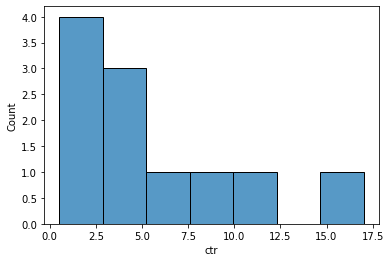

In [14]:
sns.histplot(df_a.ctr, bins=7)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

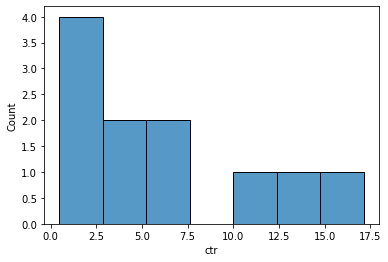

In [15]:
sns.histplot(df_b.ctr, bins=7)

In [16]:
a = stats.normaltest(df_a.ctr).pvalue
b = stats.normaltest(df_b.ctr).pvalue

alpha = 0.05
print(a > alpha, b > alpha)

True True


C:\Program Files (x86)\pit\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Нулевая гипотеза - выборки a и b статистически не различаются<br>

Так как они принадлежат нормальному распределению - можем применить тест Стьюдента


In [20]:
p_value = stats.ttest_ind(df_a.ctr, df_b.ctr).pvalue
alpha = 0.1

print(p_value, p_value > alpha)

0.937080471110325 True


Мы оставляем нулевую гипотезу и говорим о том что они из одного распрееления


### Уточнение
Мы можем предположить, что что-то измениться, если разбить на локальные группы по geo или source

In [59]:
df

,source,geo,version,shows,clicks,conversions,ctr,click_cr,absolute_conversion
0,1,DE,b,539970,9254,1000,1.714,10.806,0.185
1,1,DE,a,538560,9254,1000,1.718,10.806,0.186
2,1,IN,b,7055000,84693,1000,1.200,1.181,0.014
3,1,IN,a,7055000,76146,1000,1.079,1.313,0.014
4,1,PK,a,56000,5439,1000,9.712,18.386,1.786
5,1,PK,b,55000,5500,1000,10.000,18.182,1.818
8,2,IN,a,199615000,1048173,2500,0.525,0.239,0.001
9,2,IN,b,198972000,947940,1000,0.476,0.105,0.001
10,2,DE,b,3525000,31080,1000,0.882,3.218,0.028
11,2,DE,a,3519000,41181,1000,1.170,2.428,0.028


In [21]:
for metric in ['ctr', 'click_cr', 'absolute_conversion']:
    
    print(metric)
    sources = df.source.unique()
    for i in sources:
        df_a = df.loc[(df.version == "a") & (df.source == i)]
        df_b = df.loc[(df.version == "b") & (df.source == i)]
        res = stats.ttest_ind(df_b[metric], df_a[metric]).pvalue

        print(i, res)

    geos = df.geo.unique()
    for i in geos:
        df_a = df.loc[(df.version == "a") & (df.geo == i)]
        df_b = df.loc[(df.version == "b") & (df.geo == i)]
        res = stats.ttest_ind(df_b[metric], df_a[metric]).pvalue

        print(i, res)
    print('\n')

# Мы не можем отвергнуть нулевую гипотезу и сказать что выборки различаются

ctr
1 0.9745697775656174
2 0.7535073869447941
3 0.843971785685474
DE 0.9108485246256612
IN 0.945106209465993
PK 0.9213557896282274
CN 0.9812204639759917


click_cr
1 0.9879537121984518
2 0.8708795514462921
3 0.9828782747783236
DE 0.9569064569092445
IN 0.8830911075786427
PK 0.9750323191172872
CN 0.6272878512843283


absolute_conversion
1 0.9903793759414415
2 0.832831282747079
3 0.9770904225132644
DE 0.9969381739678738
IN 0.9584878661369682
PK 0.9921907886788932
CN 0.9981401180269688




Явно больше alpha 

### Вывод

Выборки A B тестов принадлежат одному распределению

Принимаем 0 гипотезу - средние показатели остались прежними, фичу не выпускам